In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

In [2]:
start_year = 2014
end_year = 2019

seasons = []

for year in range(start_year, end_year):
    start_date = f"{year}-09-01"
    end_date = f"{year + 1}-08-31"
    seasons.append((start_date, end_date))

In [68]:
correlation_df = pd.read_csv('../../model_results/nowcasting/elastic_net/correlation/cv_with_min_150_features/nowcasting_predictions.csv')
sentence_embedding_df = pd.read_csv('../../model_results/nowcasting/elastic_net/sentence_embedding/cv_with_min_150_features/nowcasting_predictions.csv')

/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1486596952.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_correlation_predictions['Predicted_ILI_Rate'] = filtered_correlation_predictions['Predicted_ILI_Rate'].clip(lower=0)
/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1486596952.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_textual_semantic_predictions['Predicted_ILI_Rate'] = filtered_textual_semantic_predictions['Predicted_ILI_Rate'].clip(l

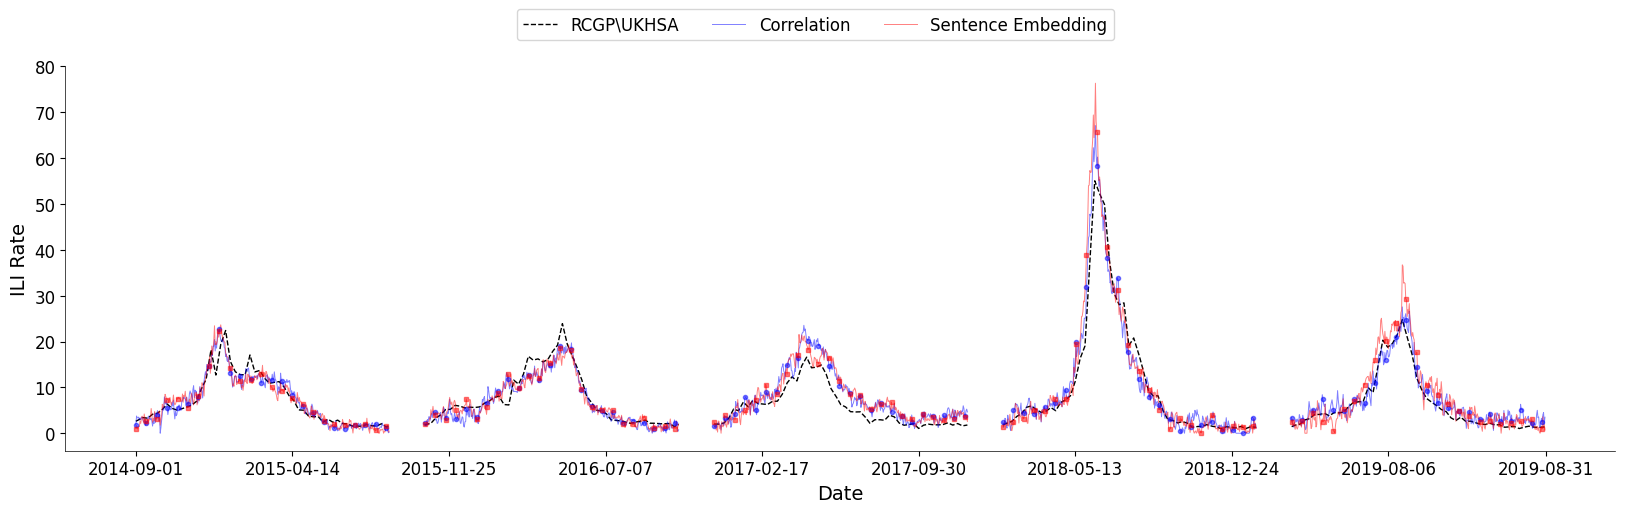

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(20, 5))

current_index = 0
plot_dates = []

for j, (start_date, end_date) in enumerate(seasons):
    season_dates = pd.date_range(start_date, end_date).tolist()
    plot_dates.extend(season_dates)

    filtered_correlation_predictions = correlation_df[(correlation_df["Date"] >= start_date) & (correlation_df["Date"] <= end_date)]
    filtered_sentence_embedding_predictions = sentence_embedding_df[(sentence_embedding_df["Date"] >= start_date) & (sentence_embedding_df["Date"] <= end_date)]

    filtered_correlation_predictions['Predicted_ILI_Rate'] = filtered_correlation_predictions['Predicted_ILI_Rate'].clip(lower=0)
    filtered_sentence_embedding_predictions['Predicted_ILI_Rate'] = filtered_sentence_embedding_predictions['Predicted_ILI_Rate'].clip(lower=0)
    
    num_days = len(filtered_correlation_predictions)
    new_indices = range(current_index, current_index + num_days)
    
    ax.plot(new_indices, filtered_correlation_predictions['Actual_ILI_Rate'], linestyle='--', color='black', alpha=1, linewidth=1, label="RCGP\\UKHSA" if j == 0 else "")
    ax.plot(new_indices, filtered_correlation_predictions['Predicted_ILI_Rate'], linestyle='-', color='blue', alpha=0.5, linewidth=0.7, label="Correlation" if j == 0 else "")
    ax.plot(new_indices, filtered_sentence_embedding_predictions['Predicted_ILI_Rate'], linestyle='-', color='red', alpha=0.5, linewidth=0.7, label="Sentence Embedding" if j == 0 else "")

    marker_interval = 15
    ax.plot(new_indices[::marker_interval], filtered_correlation_predictions.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='o', markersize=3, linestyle='', color='blue', alpha=0.5)
    ax.plot(new_indices[::marker_interval], filtered_sentence_embedding_predictions.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='s', markersize=3, linestyle='', color='red', alpha=0.5)

    current_index += num_days + (50 if j < len(seasons) - 1 else 0)

tick_indices = np.linspace(0, current_index, 10, dtype=int)
tick_dates = [plot_dates[np.abs(np.arange(len(plot_dates)) - tick).argmin()].strftime('%Y-%m-%d') for tick in tick_indices]
ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_dates)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('ILI Rate', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=4, handles=ax.get_legend_handles_labels()[0], fontsize=12)

plt.savefig('../../model_results/graphs/elastic_net_corr_sent.pdf', bbox_inches='tight')
plt.show()

In [70]:
hybrid_df = pd.read_csv('../../model_results/nowcasting/elastic_net/hybrid/cv_with_min_150_features/nowcasting_predictions.csv')

/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/2020166561.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_hybrid_predictions['Predicted_ILI_Rate'] = filtered_hybrid_predictions['Predicted_ILI_Rate'].clip(lower=0)


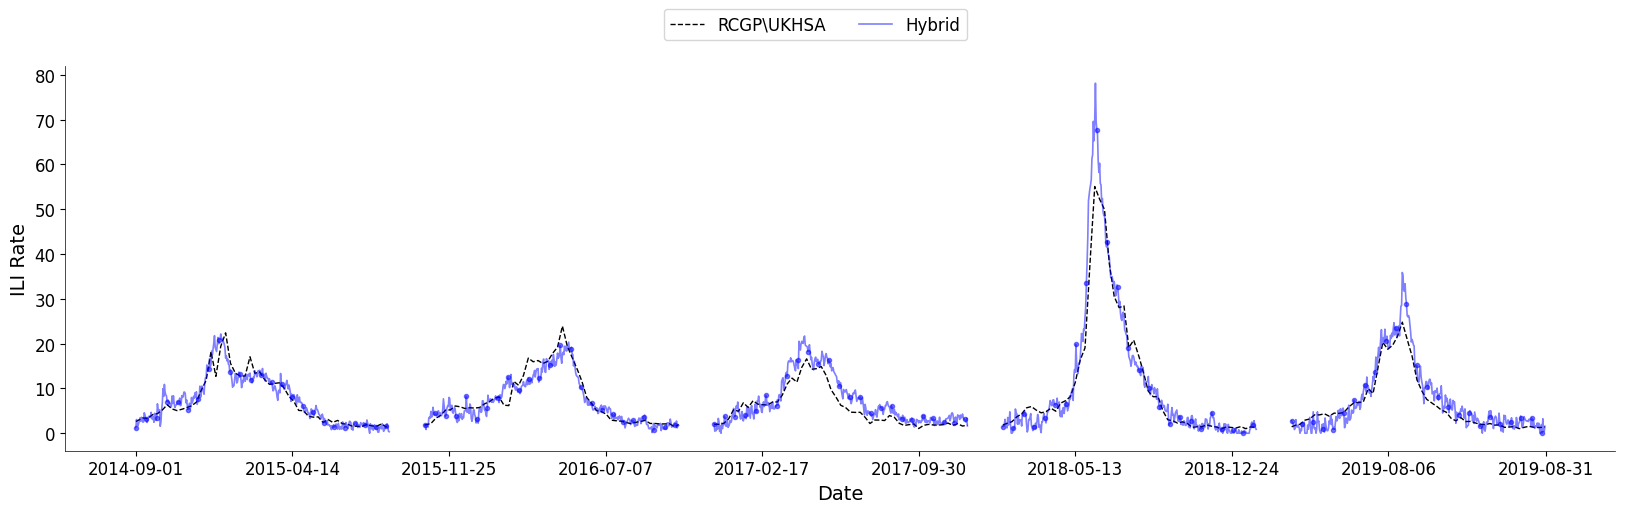

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(20, 5))

current_index = 0
plot_dates = []

for j, (start_date, end_date) in enumerate(seasons):
    season_dates = pd.date_range(start_date, end_date).tolist()
    plot_dates.extend(season_dates)

    filtered_hybrid_predictions = hybrid_df[(hybrid_df["Date"] >= start_date) & (hybrid_df["Date"] <= end_date)]
    filtered_hybrid_predictions['Predicted_ILI_Rate'] = filtered_hybrid_predictions['Predicted_ILI_Rate'].clip(lower=0)
    
    num_days = len(filtered_hybrid_predictions)
    new_indices = range(current_index, current_index + num_days)
    
    ax.plot(new_indices, filtered_hybrid_predictions['Actual_ILI_Rate'], linestyle='--', color='black', alpha=1, linewidth=1, label="RCGP\\UKHSA" if j == 0 else "")
    ax.plot(new_indices, filtered_hybrid_predictions['Predicted_ILI_Rate'], linestyle='-', color='blue', alpha=0.5, linewidth=1.2, label="Hybrid" if j == 0 else "")

    marker_interval = 15
    ax.plot(new_indices[::marker_interval], filtered_hybrid_predictions.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='o', markersize=3, linestyle='', color='blue', alpha=0.5)

    current_index += num_days + (50 if j < len(seasons) - 1 else 0)

tick_indices = np.linspace(0, current_index, 10, dtype=int)
tick_dates = [plot_dates[np.abs(np.arange(len(plot_dates)) - tick).argmin()].strftime('%Y-%m-%d') for tick in tick_indices]
ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_dates)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('ILI Rate', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=4, handles=ax.get_legend_handles_labels()[0], fontsize=12)

plt.savefig('../../model_results/graphs/elastic_net_hybrid.pdf', bbox_inches='tight')
plt.show()

In [73]:
hybrid_df = pd.read_csv('../../model_results/nowcasting/elastic_net/hybrid/cv_with_min_150_features/nowcasting_predictions.csv')
mffnn_df = pd.read_csv("../../model_results/nowcasting/neural_network/mffnn/nowcasting_predictions.csv")

/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1737872040.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_hybrid_predictions['Predicted_ILI_Rate'] = filtered_hybrid_predictions['Predicted_ILI_Rate'].clip(lower=0)
/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1737872040.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_baseline_ffnn_predictions['Predicted_ILI_Rate'] = filtered_baseline_ffnn_predictions['Predicted_ILI_Rate'].clip(lower=0)


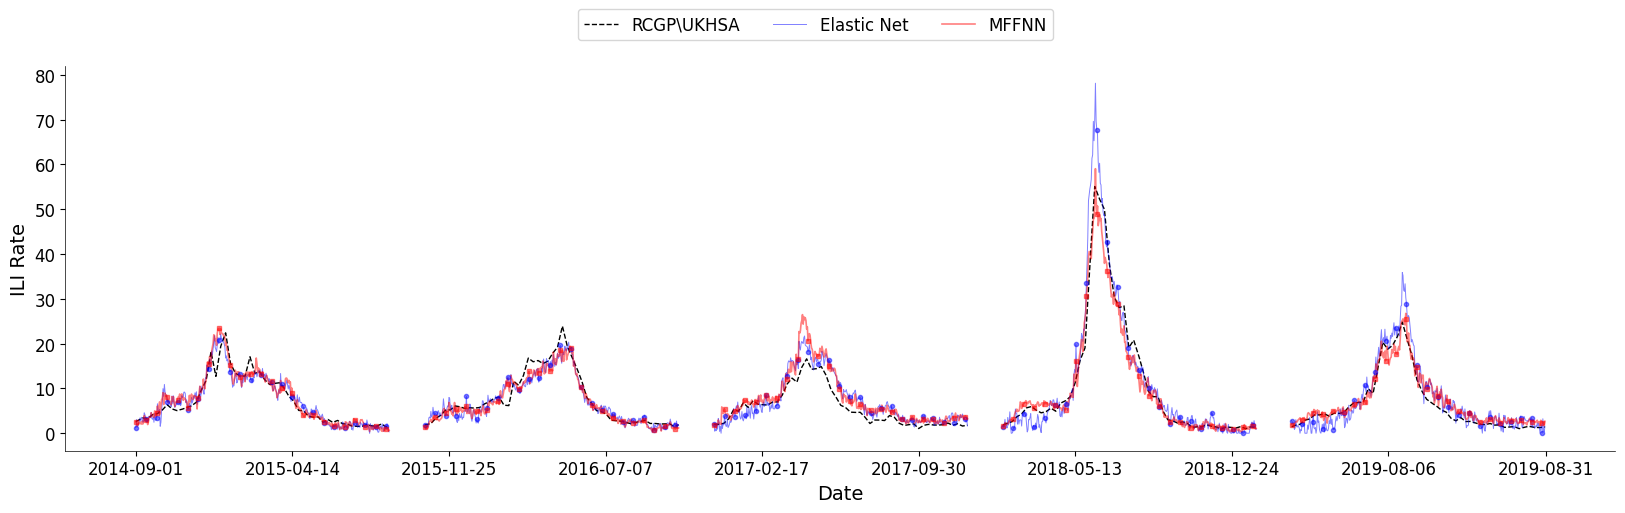

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(20, 5))

current_index = 0
plot_dates = []

for j, (start_date, end_date) in enumerate(seasons):
    season_dates = pd.date_range(start_date, end_date).tolist()
    plot_dates.extend(season_dates)

    filtered_hybrid_predictions = hybrid_df[(hybrid_df["Date"] >= start_date) & (hybrid_df["Date"] <= end_date)]
    filtered_mffnn_predictions = mffnn_df[(mffnn_df["Date"] >= start_date) & (mffnn_df["Date"] <= end_date)]

    filtered_hybrid_predictions['Predicted_ILI_Rate'] = filtered_hybrid_predictions['Predicted_ILI_Rate'].clip(lower=0)
    filtered_mffnn_predictions['Predicted_ILI_Rate'] = filtered_mffnn_predictions['Predicted_ILI_Rate'].clip(lower=0)
    
    num_days = len(filtered_hybrid_predictions)
    new_indices = range(current_index, current_index + num_days)
    
    ax.plot(new_indices, filtered_hybrid_predictions['Actual_ILI_Rate'], linestyle='--', color='black', alpha=1, linewidth=1, label="RCGP\\UKHSA" if j == 0 else "")
    ax.plot(new_indices, filtered_hybrid_predictions['Predicted_ILI_Rate'], linestyle='-', color='blue', alpha=0.5, linewidth=0.7, label="Elastic Net" if j == 0 else "")
    ax.plot(new_indices, filtered_mffnn_predictions['Predicted_ILI_Rate'], linestyle='-', color='red', alpha=0.5, linewidth=1.2, label="MFFNN" if j == 0 else "")

    marker_interval = 15
    ax.plot(new_indices[::marker_interval], filtered_hybrid_predictions.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='o', markersize=3, linestyle='', color='blue', alpha=0.5)
    ax.plot(new_indices[::marker_interval], filtered_mffnn_predictions.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='s', markersize=3, linestyle='', color='red', alpha=0.5)

    current_index += num_days + (50 if j < len(seasons) - 1 else 0)

tick_indices = np.linspace(0, current_index, 10, dtype=int)
tick_dates = [plot_dates[np.abs(np.arange(len(plot_dates)) - tick).argmin()].strftime('%Y-%m-%d') for tick in tick_indices]
ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_dates)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('ILI Rate', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=4, handles=ax.get_legend_handles_labels()[0], fontsize=12)

plt.savefig('../../model_results/graphs/MFFNN.pdf', bbox_inches='tight')
plt.show()

In [76]:
mffnn_df = pd.read_csv("../../model_results/nowcasting/neural_network/mffnn/nowcasting_predictions.csv")
dffnn_14_df = pd.read_csv("../../model_results/nowcasting/neural_network/dffnn/14_lagged/nowcasting_predictions.csv")

/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1696486185.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_baseline_ffnn_predictions['Predicted_ILI_Rate'] = filtered_baseline_ffnn_predictions['Predicted_ILI_Rate'].clip(lower=0)
/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1696486185.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ffnn_14_lagged_predictions['Predicted_ILI_Rate'] = filtered_ffnn_14_lagged_predictions['Predicted_ILI_Rate'].clip(l

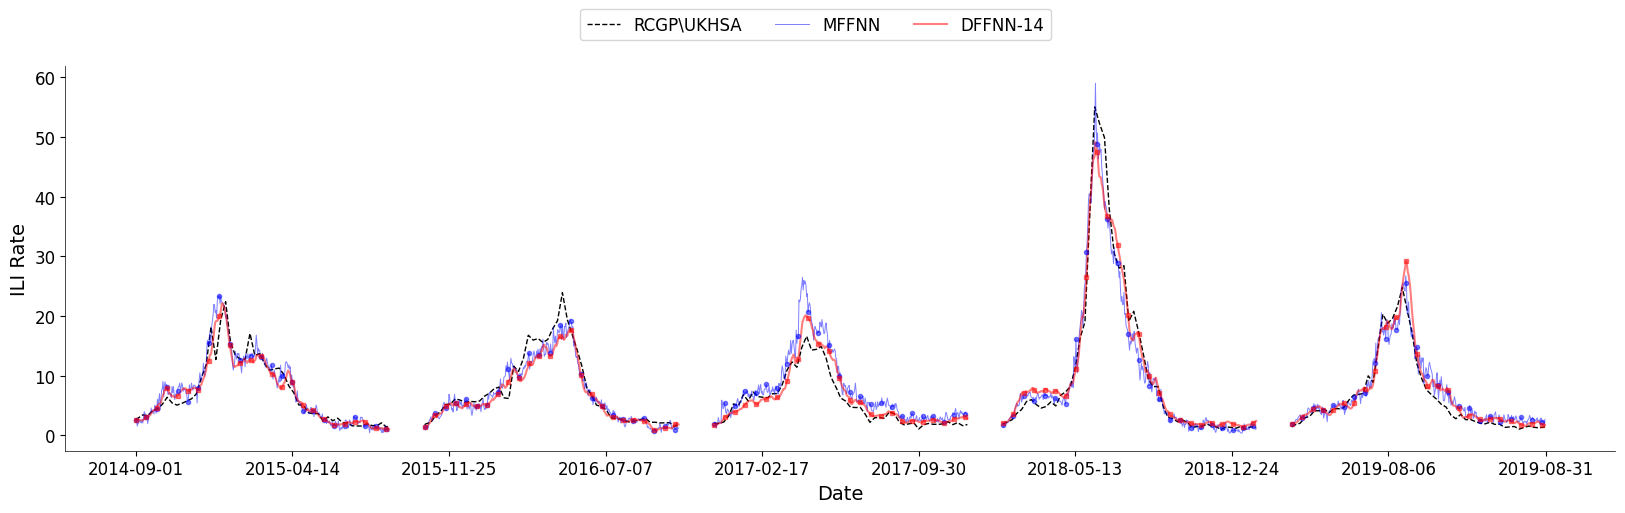

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(20, 5))

current_index = 0
plot_dates = []

for j, (start_date, end_date) in enumerate(seasons):
    season_dates = pd.date_range(start_date, end_date).tolist()
    plot_dates.extend(season_dates)

    filtered_mffnn_predictions = mffnn_df[(mffnn_df["Date"] >= start_date) & (mffnn_df["Date"] <= end_date)]
    filtered_dffnn_14_predictions = dffnn_14_df[(dffnn_14_df["Date"] >= start_date) & (dffnn_14_df["Date"] <= end_date)]

    filtered_mffnn_predictions['Predicted_ILI_Rate'] = filtered_mffnn_predictions['Predicted_ILI_Rate'].clip(lower=0)
    filtered_dffnn_14_predictions['Predicted_ILI_Rate'] = filtered_dffnn_14_predictions['Predicted_ILI_Rate'].clip(lower=0)

    num_days = len(filtered_mffnn_predictions)
    new_indices = range(current_index, current_index + num_days)
    
    ax.plot(new_indices, filtered_mffnn_predictions['Actual_ILI_Rate'], linestyle='--', color='black', alpha=1, linewidth=1, label="RCGP\\UKHSA" if j == 0 else "")
    ax.plot(new_indices, filtered_mffnn_predictions['Predicted_ILI_Rate'], linestyle='-', color='blue', alpha=0.5, linewidth=0.7, label="MFFNN" if j == 0 else "")
    ax.plot(new_indices, filtered_dffnn_14_predictions['Predicted_ILI_Rate'], linestyle='-', color='red', alpha=0.5, linewidth=1.5, label="DFFNN-14" if j == 0 else "")

    marker_interval = 15
    ax.plot(new_indices[::marker_interval], filtered_mffnn_predictions.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='o', markersize=3, linestyle='', color='blue', alpha=0.5)
    ax.plot(new_indices[::marker_interval], filtered_dffnn_14_predictions.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='s', markersize=3, linestyle='', color='red', alpha=0.5)

    current_index += num_days + (50 if j < len(seasons) - 1 else 0)

tick_indices = np.linspace(0, current_index, 10, dtype=int)
tick_dates = [plot_dates[np.abs(np.arange(len(plot_dates)) - tick).argmin()].strftime('%Y-%m-%d') for tick in tick_indices]
ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_dates)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('ILI Rate', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)


fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=4, handles=ax.get_legend_handles_labels()[0], fontsize=12)

plt.savefig('../../model_results/graphs/DFFNN-14.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_48825/4087437477.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_persistence_df['Predicted_ILI_Rate'] = filtered_persistence_df['Predicted_ILI_Rate'].clip(lower=0)
/tmp/ipykernel_48825/4087437477.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_persistence_df['Predicted_ILI_Rate'] = filtered_persistence_df['Predicted_ILI_Rate'].clip(lower=0)
/tmp/ipykernel_48825/4087437477.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

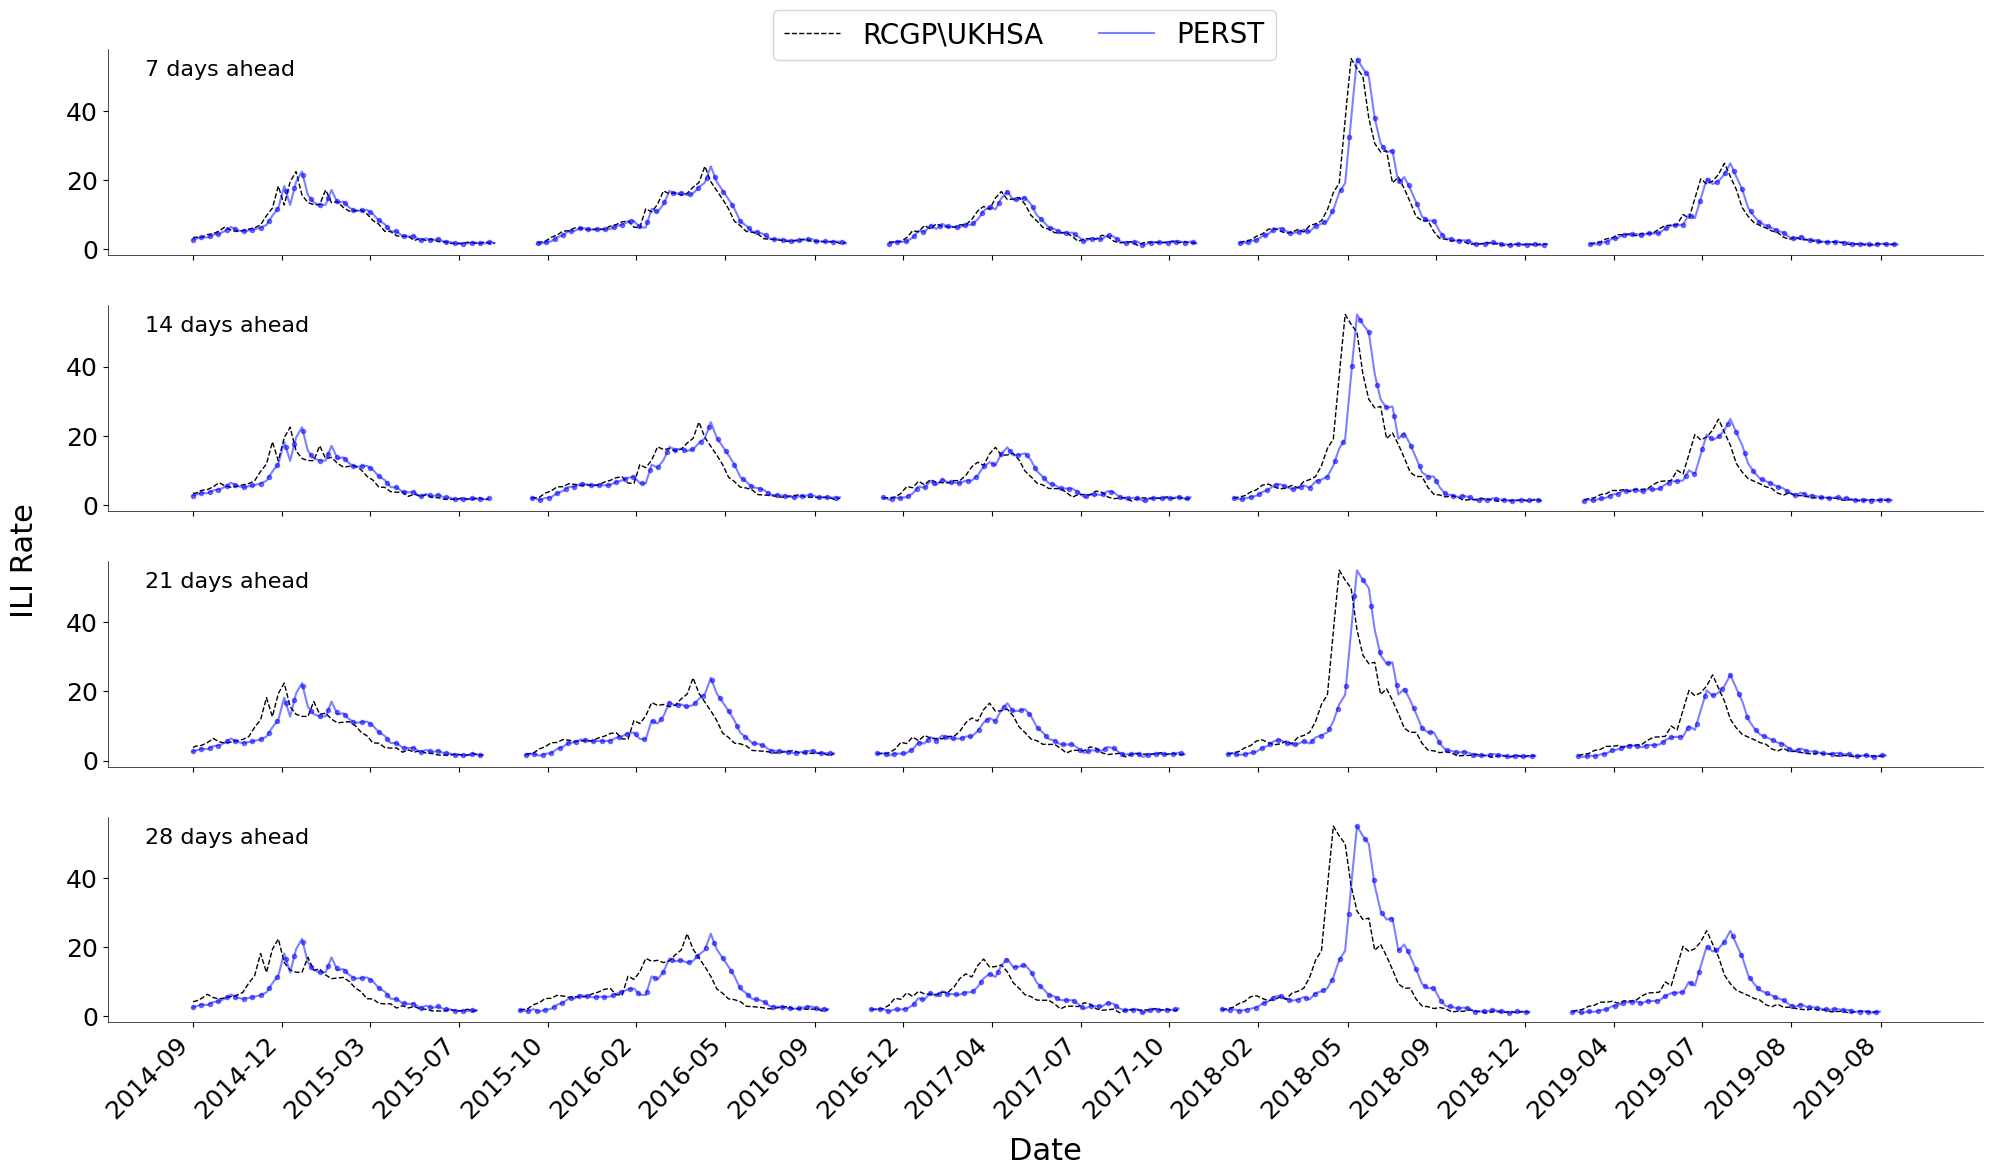

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

# Define forecasting horizons
prediction_tasks = [7, 14, 21, 28]

# Load data for each forecasting horizon
dfs = []
for forecasting_horizon in prediction_tasks:
    persistence_df = pd.read_csv(f"../../model_results/forecasting/persistence/forecasting_t+{forecasting_horizon}_predictions.csv")
    dfs.append(persistence_df)

# Create subplots for each forecasting horizon
fig, axs = plt.subplots(len(prediction_tasks), 1, figsize=(20, 12), sharex=True)

# Loop through forecasting horizons
for i, forecasting_horizon in enumerate(prediction_tasks):
    current_index = 0
    plot_dates = []

    # Loop through each season
    for j, (start_date, end_date) in enumerate(seasons):
        persistence_df = dfs[i]
        
        # Filter data for the current season
        filtered_persistence_df = persistence_df[(persistence_df["Date"] >= start_date) & (persistence_df["Date"] <= end_date)]

        # Cap minimum predicted ILI rates to 0
        filtered_persistence_df['Predicted_ILI_Rate'] = filtered_persistence_df['Predicted_ILI_Rate'].clip(lower=0)
        
        num_days = len(filtered_persistence_df)
        new_indices = range(current_index, current_index + num_days)
        season_dates = pd.date_range(start_date, end_date).tolist()
        plot_dates.extend(season_dates)
        
        # Plot ILI rates and predictions for each model
        axs[i].plot(new_indices, filtered_persistence_df['Actual_ILI_Rate'], linestyle='--', color='black', alpha=1, linewidth=1, label="RCGP\\UKHSA" if j == 0 and i == 0 else "")
        axs[i].plot(new_indices, filtered_persistence_df['Predicted_ILI_Rate'], linestyle='-', color='blue', alpha=0.5, linewidth=1.5, label="PERST" if j == 0 and i == 0 else "")

        # Add markers every 10th point for each prediction
        marker_interval = 10
        axs[i].plot(new_indices[::marker_interval], filtered_persistence_df.iloc[::marker_interval]['Predicted_ILI_Rate'], marker='o', markersize=3, linestyle='', color='blue', alpha=0.5)
 
        current_index += num_days + (50 if j < len(seasons) - 1 else 0)

    # Formatting for the last subplot
    if i == len(prediction_tasks) - 1:
        # Set x-axis tick locations and labels
        tick_indices = np.linspace(0, current_index, 20, dtype=int)
        tick_dates = [plot_dates[np.abs(np.array(range(len(plot_dates))) - tick).argmin()].strftime('%Y-%m') for tick in tick_indices]
        axs[i].set_xticks(tick_indices)
        axs[i].set_xticklabels(tick_dates, rotation=45, ha='right')  # Rotate labels by 45 degrees
        axs[i].set_xlabel('Date', fontsize=22, labelpad=10)  # Set common x-axis label with padding


    # axs[i].set_ylabel('ILI Rate')
    axs[i].text(0.02, 0.95, f"{forecasting_horizon} days ahead", transform=axs[i].transAxes, fontsize=16, verticalalignment='top')
    axs[i].tick_params(axis='both', which='major', labelsize=18)

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_linewidth(0.5)
    axs[i].spines['left'].set_linewidth(0.5)

# Set y-axis label in the middle of the figure
fig.text(0, 0.54, 'ILI Rate', va='center', ha='center', rotation='vertical', fontsize=22)

# Adjust layout and add the legend at the top
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=4, handles=axs[0].get_legend_handles_labels()[0], fontsize=20)

plt.tight_layout(pad=3.0)
plt.savefig('../../model_results/graphs/forecasting_persistence.pdf', bbox_inches='tight')
plt.show()

/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1091668217.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_baseline_ffnn_df['Predicted_ILI_Rate'] = filtered_baseline_ffnn_df['Predicted_ILI_Rate'].clip(lower=0)
/var/folders/j8/yltbx2d93432455g4jdsly8h0000gn/T/ipykernel_25713/1091668217.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ffnn_14_lagged_df['Predicted_ILI_Rate'] = filtered_ffnn_14_lagged_df['Predicted_ILI_Rate'].clip(lower=0)


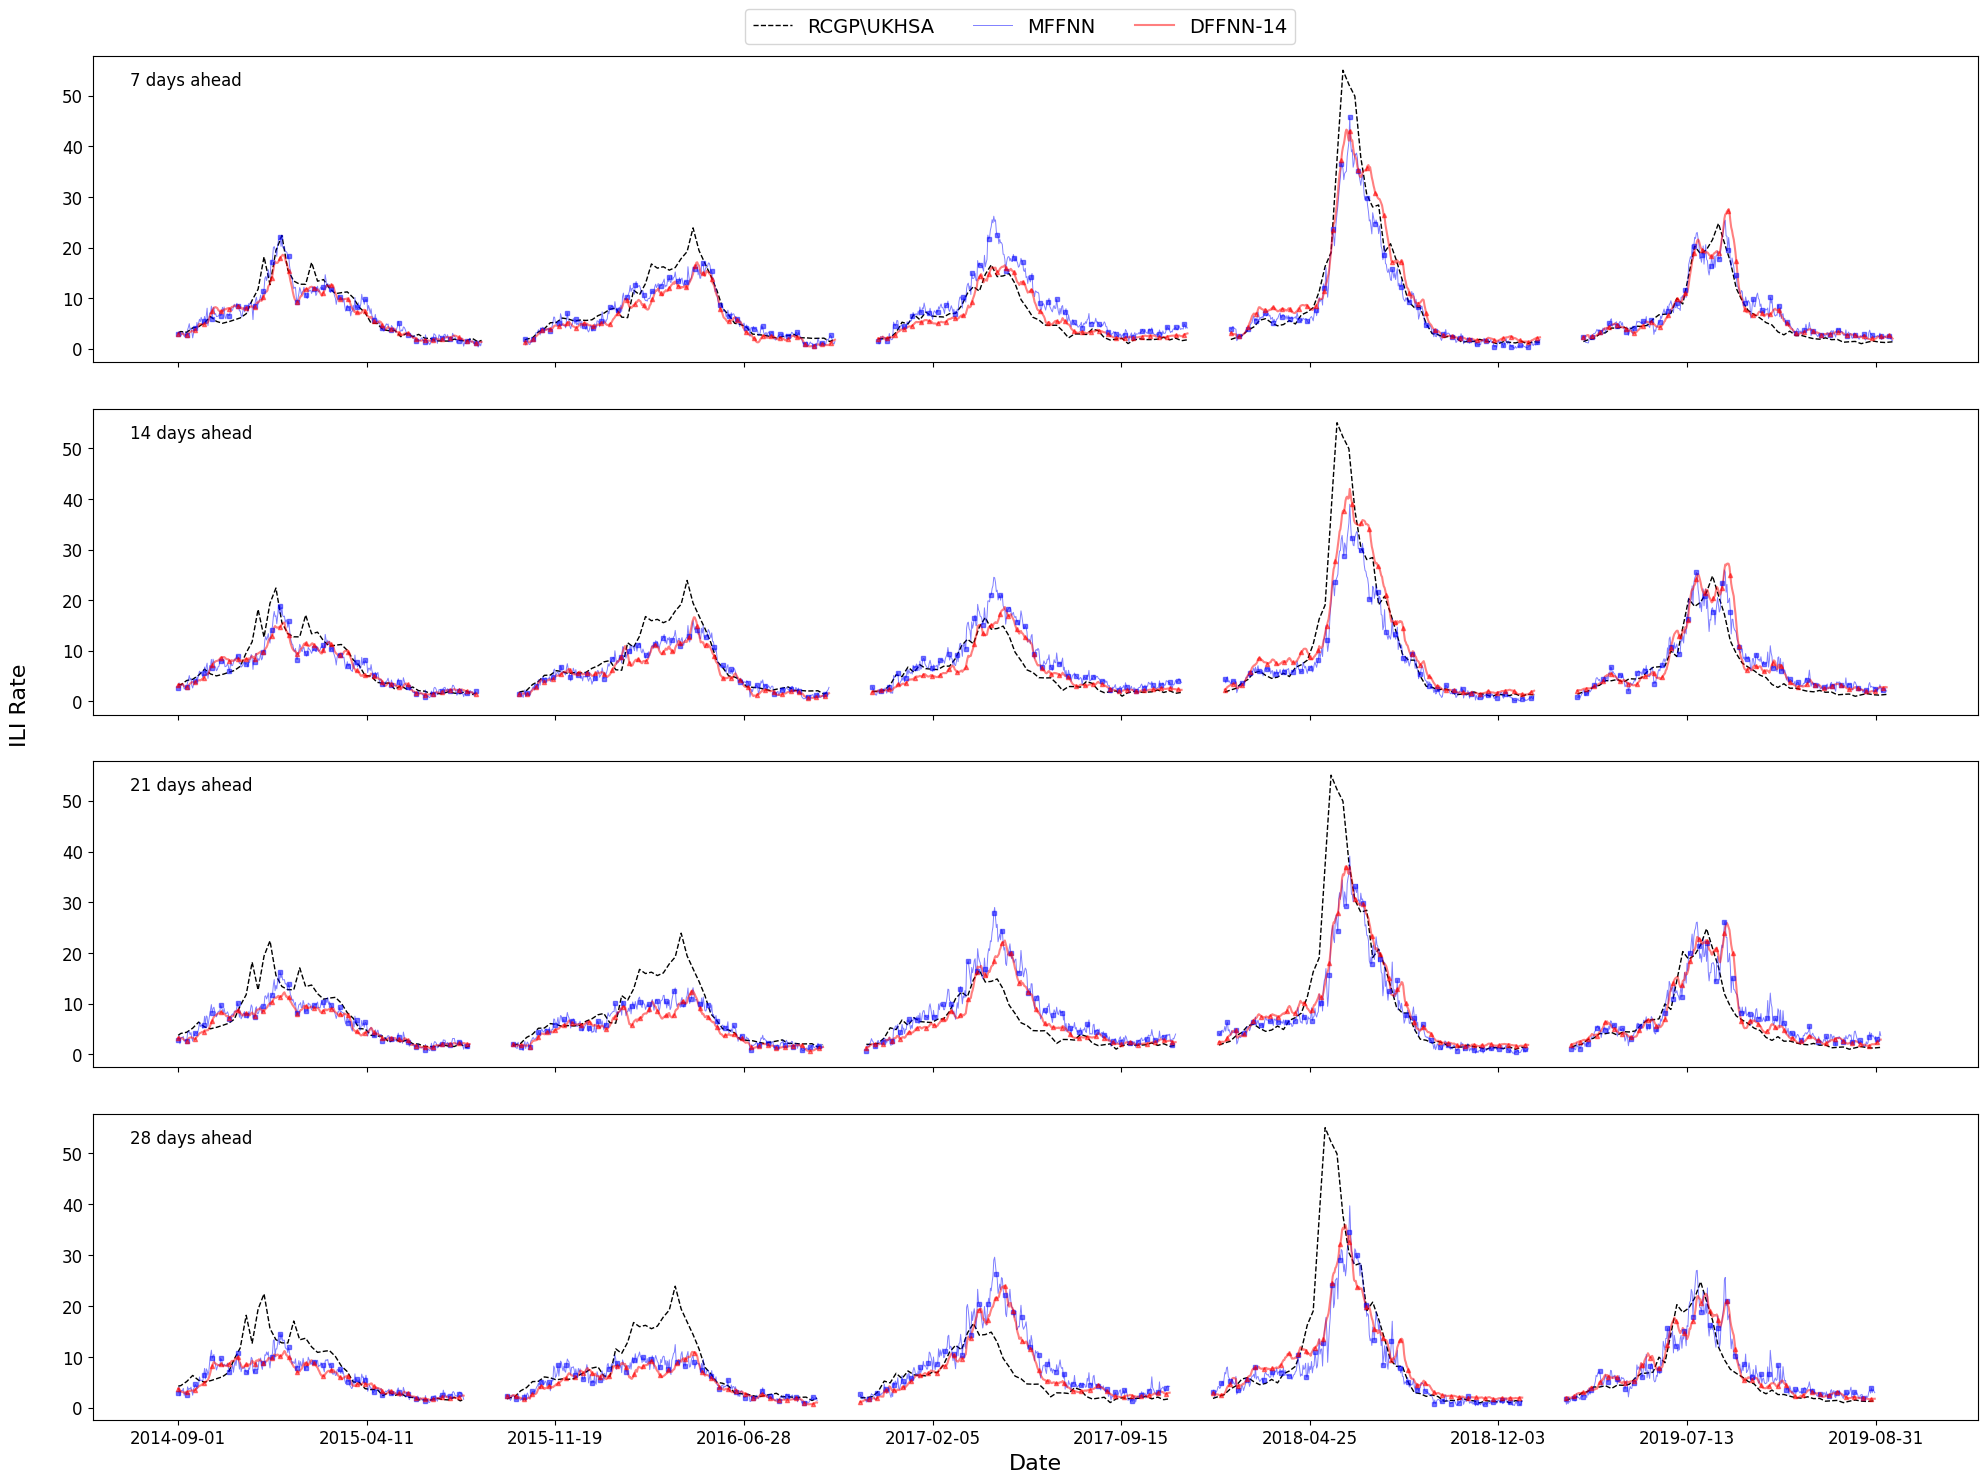

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

# Define forecasting horizons
prediction_tasks = [7, 14, 21, 28]

# Load data for each forecasting horizon
dfs = []
for forecasting_horizon in prediction_tasks:
    mffnn_df = pd.read_csv(f"../../model_results/forecasting/mffnn/forecasting_t+{forecasting_horizon}_predictions.csv")
    dffnn_14_df = pd.read_csv(f"../../model_results/forecasting/dffnn-14/forecasting_t+{forecasting_horizon}_predictions.csv")
    dfs.append((mffnn_df, dffnn_14_df))

# Create subplots for each forecasting horizon
fig, axs = plt.subplots(len(prediction_tasks), 1, figsize=(20, 15), sharex=True)

# Loop through forecasting horizons
for i, forecasting_horizon in enumerate(prediction_tasks):
    current_index = 0
    plot_dates = []

    # Loop through each season
    for j, (start_date, end_date) in enumerate(seasons):
        mffnn_df, dffnn_14_df = dfs[i]
        
        # Filter data for the current season
        filtered_mffnn_df = mffnn_df[(mffnn_df["Date"] >= start_date) & (mffnn_df["Date"] <= end_date)]
        filtered_dffnn_14_df = dffnn_14_df[(dffnn_14_df["Date"] >= start_date) & (dffnn_14_df["Date"] <= end_date)]

        # Cap minimum predicted ILI rates to 0
        filtered_mffnn_df['Predicted_ILI_Rate'] = filtered_mffnn_df['Predicted_ILI_Rate'].clip(lower=0)
        filtered_dffnn_14_df['Predicted_ILI_Rate'] = filtered_dffnn_14_df['Predicted_ILI_Rate'].clip(lower=0)
        
        num_days = len(filtered_mffnn_df)
        new_indices = range(current_index, current_index + num_days)
        season_dates = pd.date_range(start_date, end_date).tolist()
        plot_dates.extend(season_dates)
        
        # Plot ILI rates and predictions for each model
        axs[i].plot(new_indices, filtered_mffnn_df['Actual_ILI_Rate'], linestyle='--', color='black', alpha=1, linewidth=1, label="RCGP\\UKHSA" if j == 0 and i == 0 else "")
        axs[i].plot(new_indices, filtered_mffnn_df['Predicted_ILI_Rate'], linestyle='-', color='blue', alpha=0.5, linewidth=0.7, label="MFFNN" if j == 0 and i == 0 else "")
        axs[i].plot(new_indices, filtered_dffnn_14_df['Predicted_ILI_Rate'], linestyle='-', color='red', alpha=0.5, linewidth=1.5, label="DFFNN-14" if j == 0 and i == 0 else "")

        # Add markers every 10th point for each prediction
        marker_interval = 10
        axs[i].plot(new_indices[::marker_interval], filtered_mffnn_df.iloc[::marker_interval]['Predicted_ILI_Rate'], 's', markersize=3, linestyle='', color='blue', alpha=0.5)
        axs[i].plot(new_indices[::marker_interval], filtered_dffnn_14_df.iloc[::marker_interval]['Predicted_ILI_Rate'], '^', markersize=3, linestyle='', color='red', alpha=0.5)

        current_index += num_days + (50 if j < len(seasons) - 1 else 0)

    # Formatting for the last subplot
    if i == len(prediction_tasks) - 1:
        tick_indices = np.linspace(0, current_index, 10, dtype=int)
        tick_dates = [plot_dates[np.abs(np.array(range(len(plot_dates))) - tick).argmin()].strftime('%Y-%m-%d') for tick in tick_indices]
        axs[i].set_xticks(tick_indices)
        axs[i].set_xticklabels(tick_dates)
        axs[i].set_xlabel('Date', fontsize=16)  # Set common x-axis label

    # axs[i].set_ylabel('ILI Rate')
    axs[i].text(0.02, 0.95, f"{forecasting_horizon} days ahead", transform=axs[i].transAxes, fontsize=12, verticalalignment='top')
    axs[i].tick_params(axis='both', which='major', labelsize=12)

# Set y-axis label in the middle of the figure
fig.text(0, 0.54, 'ILI Rate', va='center', ha='center', rotation='vertical', fontsize=16)

# Adjust layout and add the legend at the top
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=4, handles=axs[0].get_legend_handles_labels()[0], fontsize=14)

plt.tight_layout(pad=3.0)
plt.savefig('../../model_results/graphs/forecasting_neural_nets.pdf', bbox_inches='tight')
plt.show()

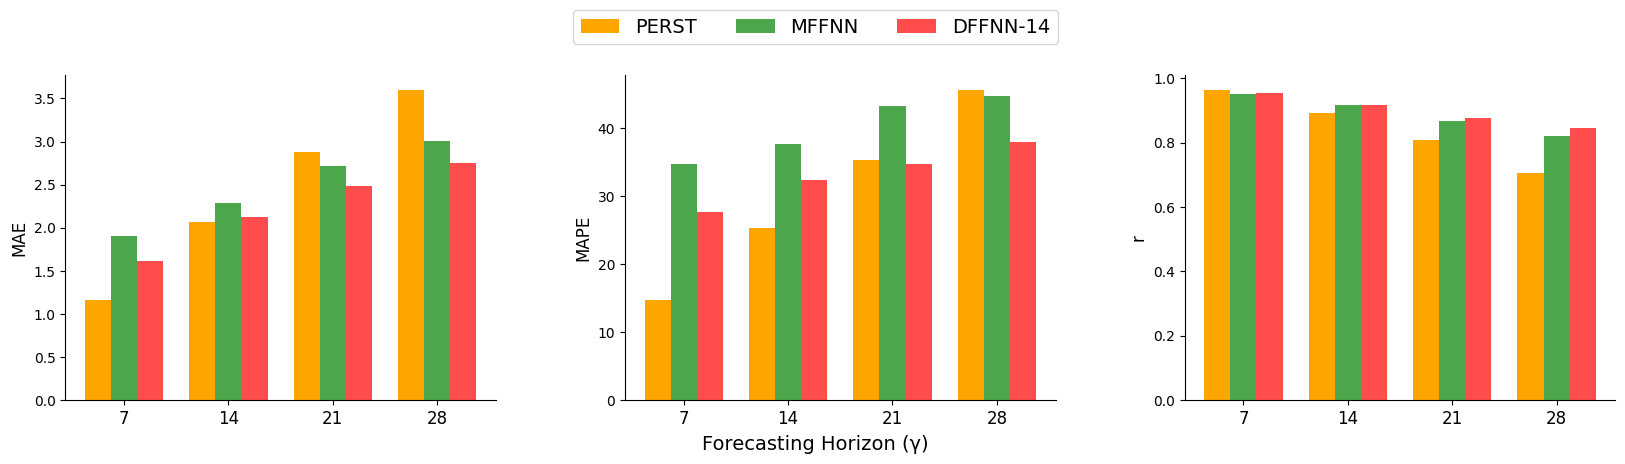

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Model names and forecasting horizons
models = ['persistence', 'mffnn', 'dffnn-14']
forecasting_horizons = [7, 14, 21, 28]

# Base directory for the results
base_dir = '../../model_results/forecasting'

# Initialize dictionaries to store the average metrics for each model and horizon
mae_values = {model: [] for model in models}
pearson_values = {model: [] for model in models}
mape_values = {model: [] for model in models}

# Reading and aggregating the data
for model in models:
    for horizon in forecasting_horizons:
        file_path = os.path.join(base_dir, f'{model}/forecasting_t+{horizon}_performance.csv')
        data = pd.read_csv(file_path)
        averages = data[data['Year'] == 'Average']

        if model == 'persistence':
            mae = averages['MAE'].values[0].split(' +-')[0]
        else:
            mae = averages['MAE'].values[0]

        mae_values[model].append(round(float(mae), 3))
        pearson_values[model].append(round(float(averages['Pearson_Correlation'].values[0]), 3))
        mape_values[model].append(round(float(averages['MAPE'].values[0]), 3))

label_mappings = {
    'persistence': "PERST" , 
    'mffnn': "MFFNN", 
    'dffnn_14': "DFFNN-14"
}

colours = [('orange', 1), ('green', 0.7), ('red', 0.7)]

print(mae_values)
print(mape_values)
print(pearson_values)

# Assuming the rest of your setup code remains the same

# Data setup
metrics_dict = {'MAE': mae_values, 'MAPE': mape_values, 'r': pearson_values}

positions = np.arange(len(forecasting_horizons))
width = 0.25  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=True)  # Share X across subplots

# Adjust subplot parameters for a clean layout
plt.subplots_adjust(bottom=0.2, top=0.85, wspace=0.3)

for i, (metric_name, metric_values) in enumerate(metrics_dict.items()):
    for j, model in enumerate(models):
        pos = [p + width*j for p in positions]
        axs[i].bar(pos, metric_values[model], width, label=label_mappings[model], color=colours[j][0], alpha=colours[j][1])
        
    axs[i].set_ylabel(metric_name, fontsize=12)  # Use y-axis label for the metric
    axs[i].set_xticks([p + width for p in positions])
    axs[i].set_xticklabels(forecasting_horizons, fontsize=12)

    # Remove the spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(True)  # Keep the left spine for the y-axis label

# Set a common x-axis label
fig.text(0.5, 0.1, 'Forecasting Horizon (γ)', ha='center', fontsize=14)

# Place a single legend at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, fontsize=14)

plt.savefig('../../model_results/graphs/forecasting_bar_chart.pdf',  bbox_inches='tight')
plt.show()